# <center>Modelling Notebook on the Prepared OWID COVID-19 Dataset</center>
<hr>

## <center>1. Reader's guide 📝</center>
<hr>
This section aims to elaborate on the modelling techniques and the data as well as the end goal of the notebook.

### 1.1 Introduction  
This notebook servers as a modelling notebook for the prepared dataset on COVID-19 in the Netherlands. The notebook will look into different models and will try to predict the `stringency_index` for the next 90 days (from the last recorded date).

### 1.2 Goal of the document
<br>
The question this notebook is going to answer are which machine learning techniques work best for the prepared data. This notebook also looks into the validation metrics, visualizations of the predictions (forecasts), and aims to give a final period of possible loosening of the stringency measures.
<br>
<br>
The models used in this notebook will be <i>Prophet</i> (both univariate and multivariate) and <i>ARIMA</i>.

## <center>2. Preparation for modelling 🎒</center>
***  
This section aims to load and split the data into training and testing.

### 2.1 Loading the data and importing the libraries 🧪

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import itertools

import datetime
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

import math
%matplotlib inline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

np.random.seed(21)

Importing plotly failed. Interactive plots will not work.


Now we can load in the data and ensure that the `date` column is in fact a `datetime` object.

In [2]:
df = pd.read_csv('./data/nl-data.csv')

In [3]:
df.head()

,date,total_cases,people_vaccinated,people_fully_vaccinated,hosp_patients,total_deaths,total_tests,stringency_index,total_cases_diff,people_fully_vaccinated_diff,hosp_patients_diff,total_deaths_diff,total_tests_diff,stringency_index_diff,total_cases_trend,total_cases_seasonal,people_vaccinated_trend,people_vaccinated_seasonal,people_fully_vaccinated_trend,people_fully_vaccinated_seasonal,hosp_patients_trend,hosp_patients_seasonal,total_deaths_trend,total_deaths_seasonal,total_tests_trend,total_tests_seasonal,stringency_index_trend,stringency_index_seasonal,total_cases_seasonal_shift_b_2m,total_cases_seasonal_shift_b_1m,total_cases_seasonal_shift_1m,total_cases_seasonal_shift_2m,total_cases_seasonal_shift_3m,people_vaccinated_seasonal_shift_b_2m,people_vaccinated_seasonal_shift_b_1m,people_vaccinated_seasonal_shift_1m,people_vaccinated_seasonal_shift_2m,people_vaccinated_seasonal_shift_3m,people_fully_vaccinated_seasonal_shift_b_2m,people_fully_vaccinated_seasonal_shift_b_1m,people_fully_vaccinated_seasonal_shift_1m,people_fully_vaccinated_seasonal_shift_2m,people_fully_vaccinated_seasonal_shift_3m,hosp_patients_seasonal_shift_b_2m,hosp_patients_seasonal_shift_b_1m,hosp_patients_seasonal_shift_1m,hosp_patients_seasonal_shift_2m,hosp_patients_seasonal_shift_3m,total_deaths_seasonal_shift_b_2m,total_deaths_seasonal_shift_b_1m,total_deaths_seasonal_shift_1m,total_deaths_seasonal_shift_2m,total_deaths_seasonal_shift_3m,total_tests_seasonal_shift_b_2m,total_tests_seasonal_shift_b_1m,total_tests_seasonal_shift_1m,total_tests_seasonal_shift_2m,total_tests_seasonal_shift_3m,stringency_index_seasonal_shift_b_2m,stringency_index_seasonal_shift_b_1m,stringency_index_seasonal_shift_1m,stringency_index_seasonal_shift_2m,stringency_index_seasonal_shift_3m
0,2020-03-01,4.500000,0.0,0.0,10.000000,0.000000,0.000000,5.560000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-7931.941964,988.445191,0.0,21460.378689,0.0,-3426.279433,-386.675000,69.444092,-955.962500,25.144118,-35745.601786,-8396.889187,13.083286,0.259736,988.445191,988.445191,NaN,NaN,NaN,21460.378689,21460.378689,NaN,NaN,NaN,-3426.279433,-3426.279433,NaN,NaN,NaN,69.444092,69.444092,NaN,NaN,NaN,25.144118,25.144118,NaN,NaN,NaN,-8396.889187,-8396.889187,NaN,NaN,NaN,0.259736,0.259736,NaN,NaN,NaN
1,2020-03-08,106.142857,0.0,0.0,67.142857,0.714286,0.000000,7.938571,101.642857,0.0,57.142857,0.714286,0.000000,2.378571,-3472.616071,-494.241175,0.0,-29927.604682,0.0,2577.078343,218.651786,-0.834777,-495.589286,13.506544,-12303.303571,2690.094332,26.323036,-0.438511,-494.241175,-494.241175,NaN,NaN,NaN,-29927.604682,-29927.604682,NaN,NaN,NaN,2577.078343,2577.078343,NaN,NaN,NaN,-0.834777,-0.834777,NaN,NaN,NaN,13.506544,13.506544,NaN,NaN,NaN,2690.094332,2690.094332,NaN,NaN,NaN,-0.438511,-0.438511,NaN,NaN,NaN
2,2020-03-15,659.285714,0.0,0.0,298.142857,8.428571,2440.000000,37.034286,451.500000,0.0,231.000000,7.000000,2440.000000,29.095714,1811.026786,-1124.247722,0.0,-19818.723730,0.0,1539.673581,764.267857,-36.722277,82.535714,-12.082444,14498.035714,4092.753856,37.053214,-0.040964,-1124.247722,-1124.247722,NaN,NaN,NaN,-19818.723730,-19818.723730,NaN,NaN,NaN,1539.673581,1539.673581,NaN,NaN,NaN,-36.722277,-36.722277,NaN,NaN,NaN,-12.082444,-12.082444,NaN,NaN,NaN,4092.753856,4092.753856,NaN,NaN,NaN,-0.040964,-0.040964,NaN,NaN,NaN
3,2020-03-22,2644.571429,0.0,0.0,1233.571429,89.428571,29273.142857,61.110000,1432.142857,0.0,935.428571,73.285714,21953.142857,24.075714,4602.821429,630.043706,0.0,28285.949723,0.0,-690.472491,1473.660714,-31.887039,307.089286,-26.568218,31041.589286,1614.040999,55.040893,0.219739,630.043706,630.043706,NaN,NaN,NaN,28285.949723,28285.949723,NaN,NaN,NaN,-690.472491,-690.472491,NaN,NaN,NaN,-31.887039,-31.887039,NaN,NaN,NaN,-26.568218,-26.568218,NaN,NaN,NaN,1614.040999,1614.040999,NaN,NaN,NaN,0.219739,0.219739,NaN,NaN,NaN
4,2020-03-29,7663.714286,0.0,0.0,2906.428571,463.142857,52558.000000,78.700000,3033.857143,0.0,1672.857143,292.714286,-27941.428571,17.590000,9118.839286,988

In [4]:
df['date'] = pd.to_datetime(df['date'])

### 2.2 Splitting the Time-Series ✂

Now we will use _scikit learn_'s `TimeSeriesSplit` to split the data and visualize how will the cross-validation technique work on this time-series analysis.

In [5]:
N_SPLITS = 3

X = df['date']
Y = df['stringency_index']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

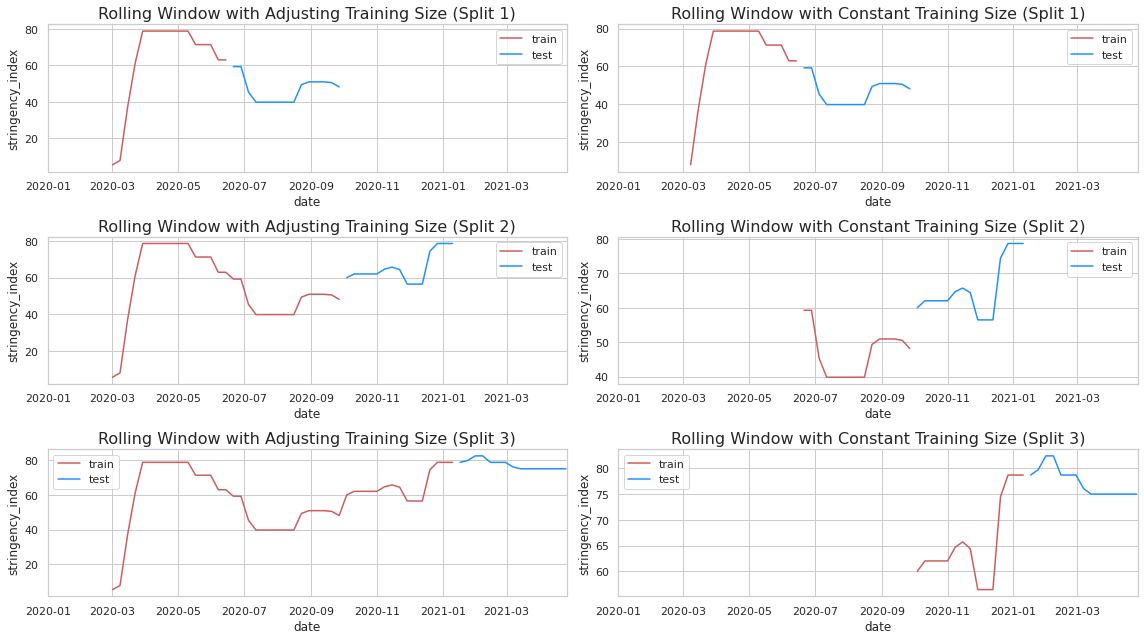

In [6]:
fig, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, test_index) in enumerate(folds.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    sns.lineplot(
        x=X_train,
        y=y_train,
        ax=ax[i, 0],
        color='indianred',
        label='train'
    )
    #print(X_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))])
    #print(y_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))])
    sns.lineplot(
        x=X_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))],
        y=y_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))],
        ax=ax[i, 1],
        color='indianred',
        label='train'
    )
    
    for j in range(2):
        sns.lineplot(
            x=X_test,
            y=y_test,
            ax=ax[i, j],
            color='dodgerblue',
            label='test'
        )
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)
    
for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2021, 4, 26)])
    ax[i, 0].ticklabel_format(style='plain', axis='y')
    ax[i, 1].ticklabel_format(style='plain', axis='y')
    
fig.tight_layout()

This plot shows us which training and testing sample are going to be used to fit the model in each iteration.  
***

Next we will take the training size and the validation size. We will be taking _90%_ for training and _10%_ for validation. This split is for the 2 univariate models - _Univariate Prophet_ and _ARIMA_.

In [7]:
train_size = int(0.90 * len(df))
test_size = len(df) - train_size

df_u = df[['date', 'stringency_index']].copy()
df_u.columns = ['ds', 'y']

train = df_u.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(df_u.iloc[:train_size, 0]), pd.DataFrame(df_u.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(df_u.iloc[train_size:, 0]), pd.DataFrame(df_u.iloc[train_size:, 1])

print(len(train), len(x_test))

54 7


We have taken these specific numbers since we do not have an abundance of data and we need to train the model. We will be using this 90-10 split since it seems the most reasonable to train a model.  
The names of the columns `ds` and `y` are taken from the Prophet's <a href="https://facebook.github.io/prophet/docs/quick_start.html#python-api">documentation</a>.

## <center>3. Hyperparameter Optimization 💿</center>
***  
This section is looking into the different sets of parameters for both ARIMA and Prophet, and finds the ones giving the lowest RMSE (Root Mean Square Error) value.

### <center>3.1 ARIMA</center>

For parameter optimization with ARIMA, we will be using `auto_arima` and we will feed it the beginning and max _p, d_, and _q_ values. We already have an idea of how are they going to look like (based on the ACF and PACF). They stand for:  
* _p_ is the number of autoregressive terms  
* _d_ is the order of differencing needed for stationarity  
* _q_ is the number of lagged forecast errors

In [8]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=7, max_q=7,
                      max_d=5, max_P=4,
                      max_D=4, max_Q=4,
                      m=4,
                      d=None,
                      seasonal=False,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic


/home/mykull/miniconda3/envs/corona/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (4) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=353.392, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=362.687, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=351.401, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=354.206, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=362.498, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=353.383, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=354.727, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=350.024, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=352.013, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=352.018, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=353.248, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=353.324, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.007 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

Based on this summary we can see that the best parameters for our model with our data is:  
* _p_ = 1  
* _d_ = 1  
* _q_ = 0

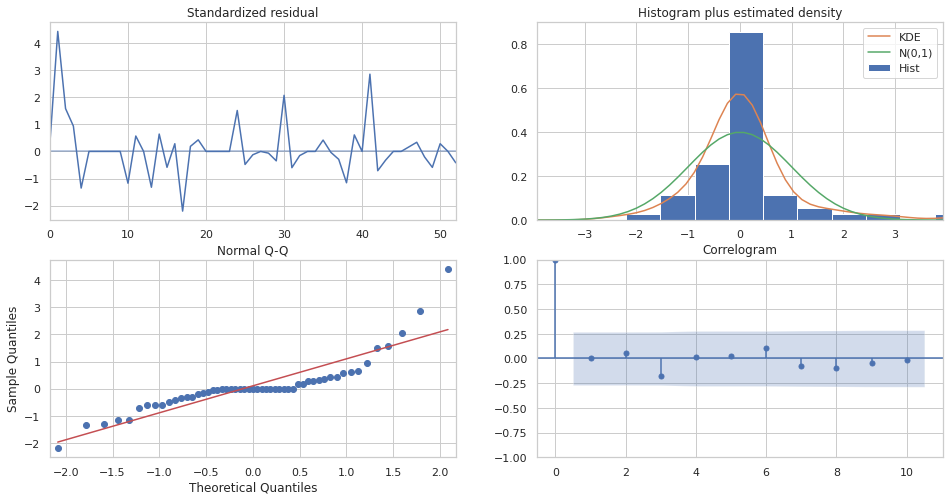

In [9]:
model.plot_diagnostics(figsize=(16, 8));

Diagnostics interpretation:  
* Top left: The residual errors seem to fluctuate around a mean of zero and have a somewhat uniform variance between (-2, 4).
* Top Right: The density plot suggest a somewhat normal distribution with mean zero.
* Bottom left: The majority of the blue dots are over the red line with some reaching over the 0.5 quantile, so it seems that the distribution is slightly skewed
* Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

### <center>3.2 Prophet</center>

In [10]:
cutoffs = pd.to_datetime(['2020-07-01', '2020-09-01', '2021-02-01'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params).fit(train)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=4)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  25.466407
1                     0.001                     0.10  25.466407
2                     0.001                     1.00  25.466407
3                     0.001                    10.00  25.466407
4                     0.010                     0.01  25.466576
5                     0.010                     0.10  25.466576
6                     0.010                     1.00  25.466576
7                     0.010                    10.00  25.466576
8                     0.100                     0.01  25.422874
9                     0.100                     0.10  25.422874
10                    0.100                     1.00  25.422874
11                    0.100                    10.00  25.422874
12                    0.500                     0.01   7.106280
13                    0.500                     0.10   7.106280
14                    0.500             

In [11]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


We can see the best parameters in the preceding printed statement.

## <center>4. Modelling</center>
<hr>
In this section we will be modelling our data using Univariate Prophet, Multivariate Prophet and ARIMA.

### <center>4.1 ARIMA</center>

The first model that we are going to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the autocorrelations in the data. The model assumes that the time-series is stationary. It consists of three main parts:  
* The AR (Autoregressive) filter which is the long-term trend -> this corresponds with the _p_ parameter (refer to the PACF)
* The Integration filter which is the stochastic trend - > this corresponds with the _d_ parameter (refer to the Differencing analysis)
* The MA (Moving Average) filter which is the short-term trend -> this corresponds with the _q_ parameter (refer to the ACF)

In [12]:
model_arima = ARIMA(y_train, order=(1,1,0))
model_arima_fit = model_arima.fit()

y_pred, se, conf = model_arima_fit.forecast(7)

score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 3.8167373229861847


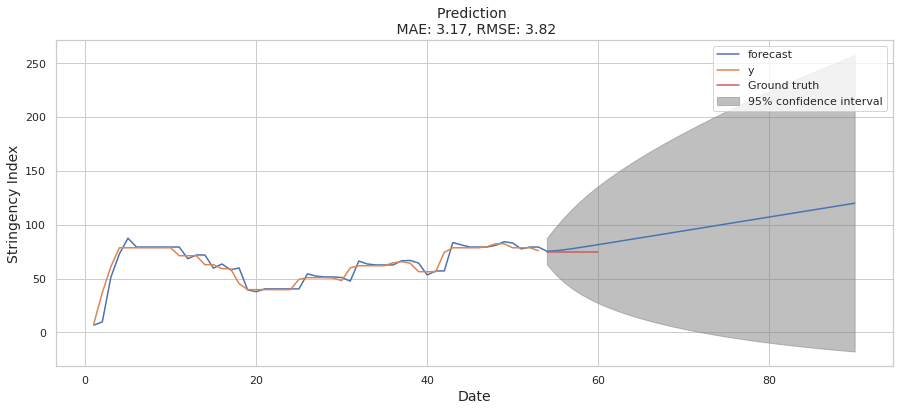

In [13]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model_arima_fit.plot_predict(1, 90, ax=ax)
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='indianred', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')

With ARIMA we see not the greatest results. In a 90-10 splits we have a RMSE (Root Mean Square Error) value of 3.82, so the prediction is off by about 4 index score. An error of 4 for a scale from 0-100 is significant and is not ideal in our situation.

### <center>4.2 Univariate Prophet</center>

The second model we are going to try is Facebook Univariate Prophet.

Prophet, or "Facebook Prophet", is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [14]:
model_up = Prophet()
model_up.fit(train)

y_pred=model_up.predict(x_test)

score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.8855881858734146


Text(100.5, 0.5, 'Stringency Index')

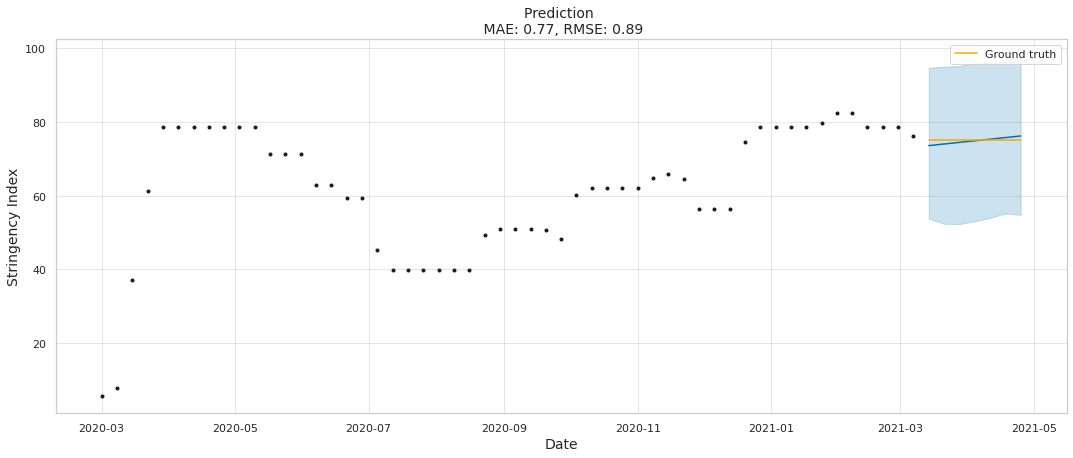

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model_up.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)

With the Univariate Prophet we can see that the model has a RMSE score of 0.89 and is really close to the ground truth.

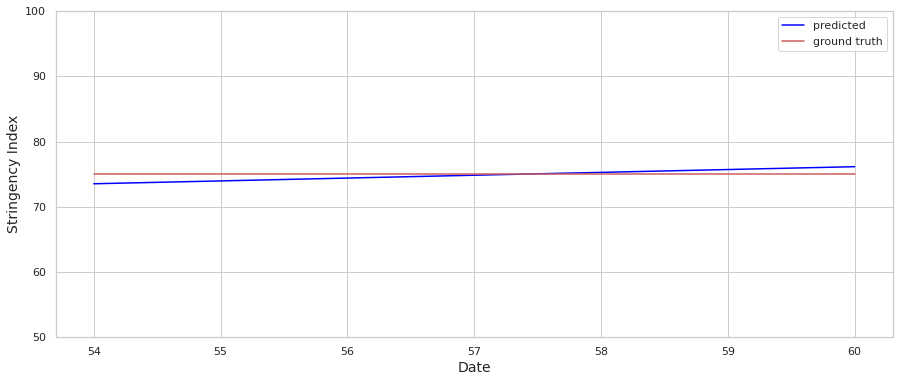

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

sns.lineplot(x=x_test.index, y=y_pred['yhat'], ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='indianred', label='ground truth')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')
ax.set_ylim([50, 100])

fig.show()

The preceding is a zoomed-in plot of the prediction.  
***  
Overall, Univariate Prophet seems to give us really good results with error of about 0.9 of the stringency index.

### <center>4.3 Multivariate Prophet</center>

Finally, we are going to analize multivariate time-series forecasting.

Multivariate time series: Multiple variables are varying over time. There are four features we are interested in, the `stringency_index` (target), the `total_cases`, `people_vaccinated`, `people_fully_vaccinated`, and they vary simultaneously over time.  

We will also split the data once again this time for solving the problem with 3 variables (features).

In [17]:
feature_columns = [
    'total_cases',
    'people_vaccinated',
    'people_fully_vaccinated'
]
target_column = ['stringency_index']

train_size = int(0.90 * len(df))

df_mp = df[['date'] + target_column + feature_columns].copy()
df_mp.columns = ['ds', 'y'] + feature_columns

train = df_mp.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(df_mp.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(df_mp.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(df_mp.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(df_mp.iloc[train_size:, 1])

We will be adding regressors for the `total_cases`, `people_vaccinated`, and `people_fully_vaccinated` due to the correlation they have (reference the correlation heatmap in the Data Preparation Notebook) in the original and shifted values.

In [18]:
model_mp = Prophet()

model_mp.add_regressor('total_cases')
model_mp.add_regressor('people_vaccinated')
model_mp.add_regressor('people_fully_vaccinated')

model_mp.fit(train)

y_pred = model_mp.predict(x_test)

score_mae = mean_absolute_error(y_test, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.3467048766599505


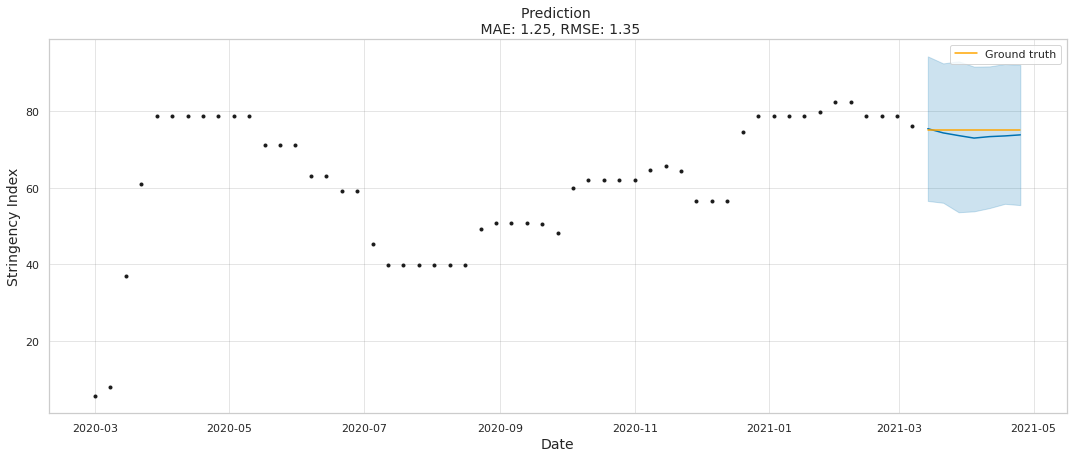

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

model_mp.plot(y_pred, ax=ax)

sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)

fig.show()

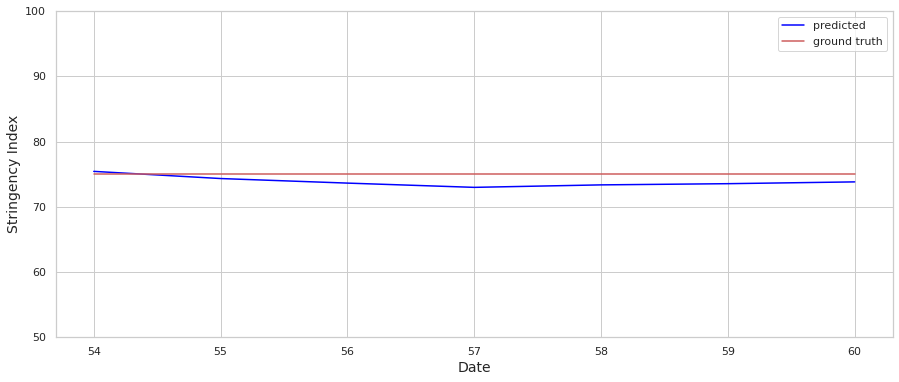

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

sns.lineplot(x=x_test.index, y=y_pred['yhat'], ax=ax, color='blue', label='predicted')
sns.lineplot(x=x_test.index, y=y_test['y'], ax=ax, color='indianred', label='ground truth')

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Stringency Index', fontsize=14)
ax.ticklabel_format(style='plain', axis='y')
ax.set_ylim([50, 100])

fig.show()

Multivariate Prophet also gave us really good results with just about 1.4 error in the stringency index with a RMSE of 1.35. Overall, the best result was given by _Univariate Prophet_ followed by _Multivariate Prophet_ and the worst result given by _ARIMA_.  
***  
Now we can finalize by predicting and visualizing our predictions.

## <center>5. Predicting 📈</center>
***  
This section looks into the model we have trained and visualizes its predictions for a period of 90 days. The model that will be used to forecast is going to be the _Univariate Prophet_. This section also includes the serialization of the model to be used externally.

### <center>5.1 Univariate Prophet</center>

In [21]:
future = model_up.make_future_dataframe(periods=90)
future.tail()

,ds
139,2021-06-01
140,2021-06-02
141,2021-06-03
142,2021-06-04
143,2021-06-05


Legend of the columns:  
* `ds`: datetimestamp is the datetime object required by Prophet  
* `yhat`: predicted value based on the lower and upper results  
* `yhat_lower`: lower boundry of the predicted value  
* `yhat_upper`: upper boundry of the predicted value

In [22]:
forecast = model_up.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
139,2021-06-01,78.458859,57.329077,99.792832
140,2021-06-02,78.521150,57.434034,98.402700
141,2021-06-03,78.583442,58.241177,98.326203
142,2021-06-04,78.645734,57.290876,99.700618
143,2021-06-05,78.708026,58.909222,100.993836


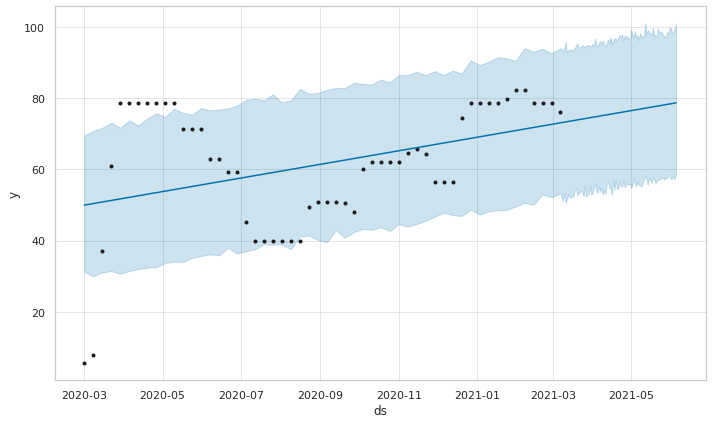

In [23]:
model_up.plot(forecast);

In [24]:
forecast[['yhat']].tail()

,yhat
139,78.458859
140,78.521150
141,78.583442
142,78.645734
143,78.708026


We can conclude that based on our prediction interval of 90 days, with the current trends, the lockdown measures will not disperse any time soon. The model suggests that the `stringency index` is likely to continue growing.  
***

### <center>5.2 Saving the Model 💾</center>
<hr>
In order to save the model and make it usable by the majority of services, we will serialize the model in the form of a <code>json</code>.

In [25]:
import json
from fbprophet.serialize import model_to_json

with open('./out/stringency_prophet_model.json', 'w') as fout:
    json.dump(model_to_json(model_up), fout)

## <center>6. Conclusion ✔</center>
<hr>
In this section, we will be giving an executive summary of the modelling process, as well as next steps for deployment, usage and demonstration of the model.

### 6.1 Model Deployment and Usage 🚩
***  
We will be storing the model in the form of a `.json` file. As we do not have an API the easiest way to provide the functionality of the model will be in this format. For later stages there could be a public facing API, as well as a _DVC (data version control)_ solution to keep track of the changes in the model. This could all be executed in the form of a pipeline on the cloud that takes in the daily data and retrains the model daily.

### 6.2 Summary 📔  
***  
We have used 3 time-series machine learning models, namely _ARIMA_, _Univariate Prophet_, and _Multivariate Prophet_. We have found the best success with the _Univariate Prophet_ and we have made a 90-day prediction about the `stringency index` and how it changes over the period. These are the main points we looked over:  
* We have split the time-series data into training and testing for both the univariate and multivariate models  
* We have visualized the split for both the original (constant) data and its lagged counterpart  
* We have run a hyperparameter tuning techniques for the models  
* We have fitted the 3 models and calculated the relevant metrics - RMSE (Root Mean Square Error) and MAE (Mean Absolute Error)  
* We have visualized the model fittings  
* We have predicted the next 90-day trend with the most performant model - _Univariate Prophet_  
* We have serialized and saved the model in the form of a `.json` file  
***

## References:  
* ARIMA vs Prophet for time series forecasting - <a href="https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a">https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a</a>  
* ARIMA models and demos - <a href="https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06">https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06</a>  
* Complete guide to time series forecasting - ARIMA and Auto-ARIMA - <a href="https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/">https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/</a>  
* ARIMA - <a href="https://people.duke.edu/~rnau/411arim2.htm">https://people.duke.edu/~rnau/411arim2.htm</a>  
* Prophet Docs - <a href="https://facebook.github.io/prophet/docs/quick_start.html">https://facebook.github.io/prophet/docs/quick_start.html</a>  
* Statsmodels Docs - <a href="https://www.statsmodels.org/stable/index.html">https://www.statsmodels.org/stable/index.html</a>  